In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import TimeDistributed as td
from keras.layers import Input, Conv2D, Flatten, Dense, ZeroPadding2D, Activation, concatenate
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape, UpSampling2D
from keras.models import Model

In [2]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5

        x.append(im)

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

In [3]:
def conv_block(tensor, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    x = Conv2D(filters=nfilters, kernel_size=(size,size) , padding=padding, kernel_initializer = 'he_normal')(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
  
def deconv_block(tensor, residual, nfilters, size=3, padding='same', kernel_initializer = 'he_normal'):
    y = UpSampling2D(size = (2,2))(tensor)
    y = Conv2D(filters=nfilters, kernel_size=(size,size), activation = 'relu', padding = 'same', kernel_initializer = kernel_initializer)(y)
    y = concatenate([y,residual], axis = 3)
    y = conv_block(y, nfilters)
    
    return y   
     


In [4]:
def get_jnet():
    inputs = Input((224,224,3))
    
    conv1 = conv_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = conv_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=2)(conv2)

    conv3 = conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 128)
    pool4 = MaxPooling2D(pool_size=2)(conv4)
   
    conv5 = conv_block(pool4, 256)
   

    up6 = deconv_block(conv5, conv4, 128)
    up7 = deconv_block(up6, conv3, 64)
    up8 = deconv_block(up7, conv2, 32)
    up9 = deconv_block(up8, conv1, 16)
    
    pool_fin = MaxPooling2D(pool_size=2)(up9)
    conv10 = Conv2D(64, kernel_size=(14, 14), strides=(14, 14))(pool_fin)
    out = BatchNormalization()(conv10)
    out = Reshape((64, 64))(out)
    out = Activation('softmax')(out)

    model = Model(inputs=[inputs], outputs=[out])

    return model

In [5]:
model = get_jnet()
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [6]:
base_path = "../input/jigsaw-puzzle/Gravity Falls/puzzle_8x8/"

In [7]:
x_train, y_train = load_data(base_path, 'train', pieces=8)

In [8]:
x_val, y_val = load_data(base_path, 'valid', pieces=8)

In [9]:
weightpath = "best_weights_8x8_1.hdf5"
checkpoint = ModelCheckpoint(weightpath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_val, y_val), callbacks=callbacks_list)

filepath="puzzle_8x8.hdf5"
model.save(filepath)

Epoch 1/60
18/18 [==============================] - 233s 13s/step - loss: 3.9905 - sparse_categorical_accuracy: 0.0647 - val_loss: 4.4172 - val_sparse_categorical_accuracy: 0.0186
Epoch 2/60
18/18 [==============================] - 227s 13s/step - loss: 3.2018 - sparse_categorical_accuracy: 0.2499 - val_loss: 4.0720 - val_sparse_categorical_accuracy: 0.0553
Epoch 3/60
18/18 [==============================] - 230s 13s/step - loss: 2.4763 - sparse_categorical_accuracy: 0.5034 - val_loss: 3.9816 - val_sparse_categorical_accuracy: 0.0661
Epoch 4/60
18/18 [==============================] - 233s 13s/step - loss: 1.9822 - sparse_categorical_accuracy: 0.6729 - val_loss: 3.8790 - val_sparse_categorical_accuracy: 0.0973
Epoch 5/60
18/18 [==============================] - 242s 14s/step - loss: 1.6331 - sparse_categorical_accuracy: 0.7708 - val_loss: 3.7536 - val_sparse_categorical_accuracy: 0.1602
Epoch 6/60
18/18 [==============================] - 228s 13s/step - loss: 1.3987 - sparse_categorica

In [10]:
pd.Series({k:v[-1] for k, v in history.history.items()})

loss                               0.056864
sparse_categorical_accuracy        0.999943
val_loss                           0.744540
val_sparse_categorical_accuracy    0.861080
dtype: float64

In [11]:
def plot_loss_accuraccy(history):
    history_df = pd.DataFrame(history.history)
    print("Maximum accuracy: {}".format(history_df['val_sparse_categorical_accuracy'].max()))
    history_df[['loss', 'val_loss']].plot()
    history_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

Maximum accuracy: 0.8782670497894287


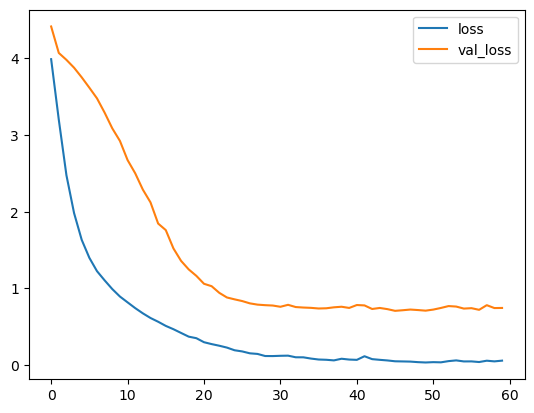

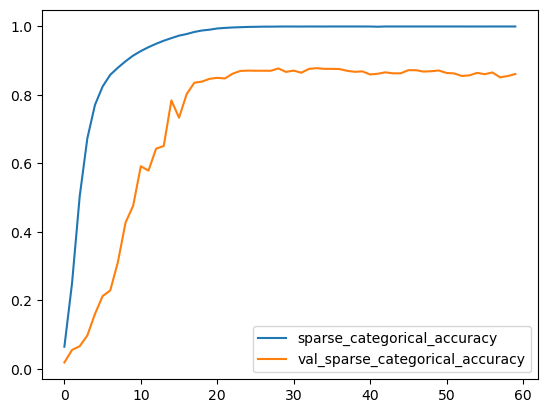

In [12]:
plot_loss_accuraccy(history)

## Test model

In [13]:
model = keras.models.load_model('puzzle_8x8.hdf5')

In [14]:
pieces = 8
x_test, y_test = load_data(base_path, 'test', pieces=pieces)

In [15]:
y_pred = model.predict(x_test)
predict = [np.argmax(y, axis=1) for y in y_pred]
accuracy = np.mean(keras.metrics.categorical_accuracy(y_test.reshape(-1, 8*8), predict))

print("Accuracy on {} samples: {}%".format(len(y_pred), accuracy*100))

4/4 [==============================] - 5s 1s/step
Accuracy on 110 samples: 58.1818163394928%


In [16]:
def rearrange(im, label, pieces=4, dim=224, channel=3):
    cut_len = dim // pieces

    new_im = np.zeros((dim, dim, channel))
    for i in range(pieces):

        hor_cut = im[i * cut_len:(i + 1) * cut_len]

        for j in range(pieces):
            piece = hor_cut[:, j * cut_len:(j + 1) * cut_len]

            pos = label[i * pieces + j]
            x = pos // pieces
            y = pos % pieces

            new_im[x * cut_len:(x + 1) * cut_len, y * cut_len:(y + 1) * cut_len] = piece

    return new_im

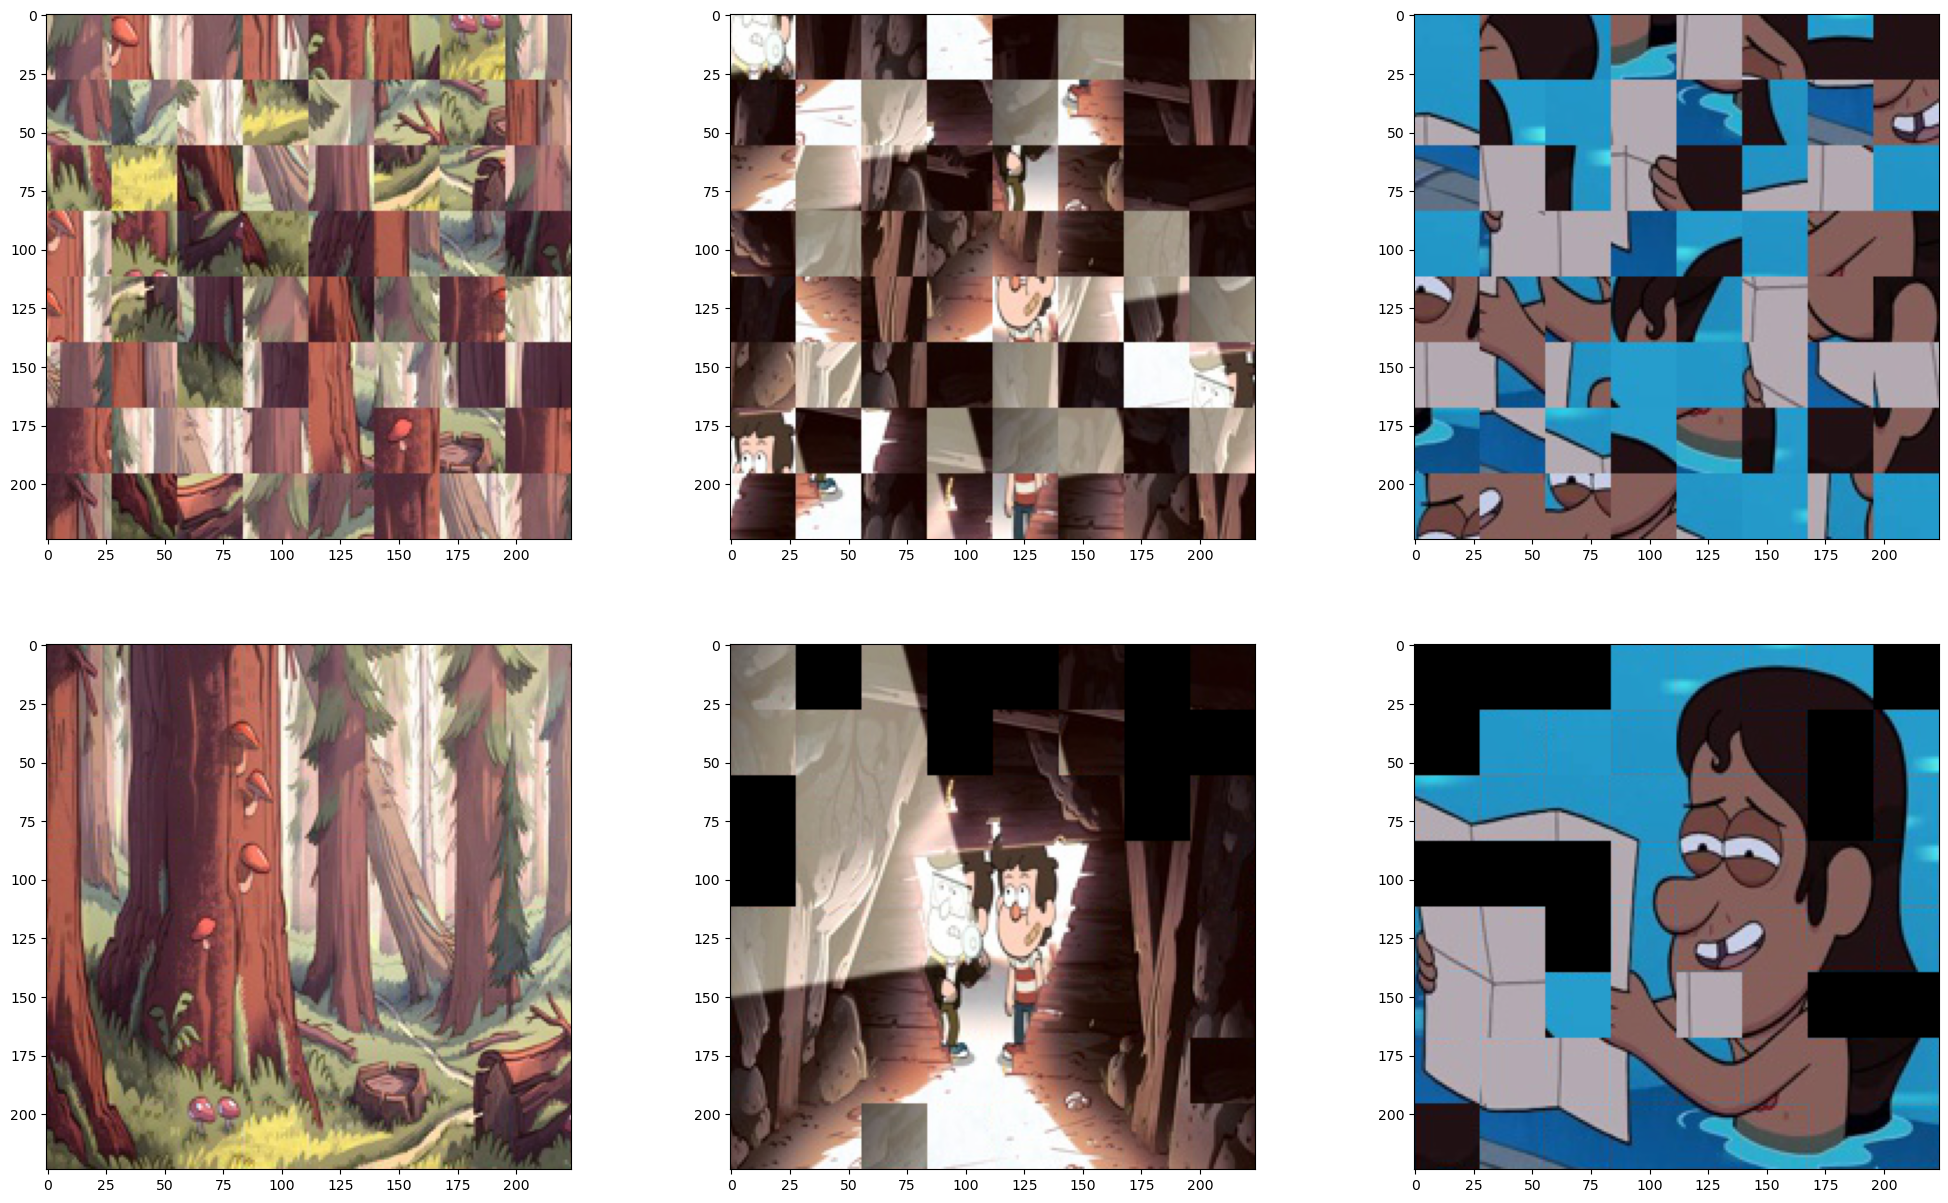

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(25, 15))
indexes = np.random.randint(len(x_test), size=3)

for i, idx in enumerate(indexes):
    image = x_test[idx].astype('float64')+.5
    ax[0, i].imshow(image)

    y_pred_idx = np.argmax(y_pred[idx], axis=1)
    arrange_img = rearrange(image, y_pred_idx, pieces)
    ax[1, i].imshow(arrange_img)